# ***Overfitting ve Regularizasyon***

## ***Ev Fiyatlari***

Ev Fiyatları verilerini [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)'dan indirin.

- Önceki alistirmadaki modelinizi yeniden uygulayın.

- Aynı model tanımını kullanarak OLS, Lasso, Ridge ve ElasticNet regresyonlarını deneyin. Bu kez, modelleriniz için en iyi hiperparametre değerlerini seçmek için k-fold çapraz doğrulama yapmanız gerekir. Hangi model en iyisidir? Açıklayın?

---
### ***Baslangic Modeli: Butun Degiskenlerden Anlamli Olmayanlar Cikarilarak***
- Burada ev fiyatlari veri setindeki kategorik degiskenler encode edilerek numerik yapilmis ve modele katilmistir. Butun degiskenler kullanilarak birinci defa olusturulan modelden p degeri yuksek (pval>0.005) degiskenlerin cikarilarak kalan degiskenlerle olusturulan nihai model secilmistir. Bu model digerlerine nispeten iyi performansli oldugundan regularizasyon ile iyilestirmesinde hissedilir katki olmayabilir.

In [31]:
import pandas as pd
import numpy as np
# grafiksel araclar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
# lineer regresyon icin
from sklearn import linear_model
import statsmodels.api as sm
# polynomial features icin
from sklearn.preprocessing import PolynomialFeatures
# egitim verisini ayirmak icin
from sklearn.model_selection import train_test_split
# tahmin performansi icin
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
# regularizasyon icin
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
# path ile calismak icin
import sys
# dosyanin bulundugu dizini path e ekledik
mylib = '/home/admin1/datascience/datascience/library'
if mylib not in sys.path:
    sys.path.insert(1, mylib)
# parser i kullanabilmek icin
from data_description_parser import data_description_house_prices
data_dict = data_description_house_prices()

# uyarilari dikkate alma
import warnings
warnings.filterwarnings('ignore')

# pandas varsayilan olarak cok sayida sutun veya satir varsa tumunu gostermez
# bu nedenle 100 sutun ve satir gostermesi icin
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# virgulden sonra belirli sayida basamak gosterimi icin 
pd.options.display.float_format = '{:,.3f}'.format
# aciklama sutunun tam cikmasi icin
pd.options.display.max_colwidth = 100

# font tanimlamalari
title_font = {'family': 'times new roman', 'color': 'darkred','weight': 'bold','size': 14}
axis_font  = {'family': 'times new roman', 'color': 'darkred','weight': 'bold','size': 14}

# temiz veri setini dataframe icerisine yukle (outlierlarin bir kismi temizlenmis)
house_prices = pd.read_csv('data/house_prices_out.csv',index_col='Id')

- Sonuclar dataframe olusturularak kaydedilecek.

In [32]:
# performans sonuclarini tutacak df
results_df = pd.DataFrame(columns=['description', 'rsquared_train', 'rsquared_test', 
                                   'MAE', 'MSE', 'RMSE', 'MAPE'])
results_df.index.name = 'model' 


- Fonksiyon tanimlamalari

In [33]:
# sonuclari kaydeden fonksiyon
def save_results(regression, model_nu, x_train, x_test, y_train, y_test, y_preds, description):
    # global degiskeni degistirmek istiyorsak fonksiyon icersinde bu tanimlama olmali
    global results_df
    new = 0
    # model_nu varsa ustune yaz yoksa yeni olustur concat et
    if ((results_df.index == model_nu).any()):
        df = results_df
    else:
        df = pd.DataFrame([])
        df.index.name = 'model'
        new = 1
    df.loc[model_nu,'description'] = description
    df.loc[model_nu,'rsquared_train'] = regression.score(x_train, y_train)
    df.loc[model_nu,'rsquared_test'] = regression.score(x_test, y_test)
    df.loc[model_nu,'MAE'] = mean_absolute_error(y_test, y_preds)
    df.loc[model_nu,'MSE'] = mse(y_test, y_preds)
    df.loc[model_nu,'RMSE'] = rmse(y_test, y_preds)
    df.loc[model_nu,'MAPE'] = np.mean(np.abs((y_test - y_preds) / y_test)) * 100   
    
    if new == 1:        
        results_df = pd.concat([results_df, df])
        
# tahmin ve gercek deger grafigini cizdiren fonksiyon  
def make_plot(y_test, y_test_pred, y_train, y_train_pred):   
    plt.figure(dpi = 100)
    # gercek degerler ve tahmin degerleri
    # egitim tahminleri
    plt.scatter(y_train, y_train_pred, label='train')
    # test tahminleri
    plt.scatter(y_test, y_test_pred, label='test', alpha=0.7)
    # gercek degerlerin cizgisi
    plt.plot(y_test, y_test, color="red")
    plt.xlabel("Gerçek Değerler", fontdict=axis_font)
    plt.ylabel("Tahmin edilen Değerler", fontdict=axis_font)
    # rmse degerlerini annotate ile grafige yazabiliriz
    plt.annotate('RMSE test  : {:.2f}'.format(rmse(y_test,y_test_pred)), xy=(600000,200000))
    plt.annotate('RMSE train : {:.2f}'.format(rmse(y_train,y_train_pred)), xy=(600000,100000))
    plt.title("Satis Fiyati: Gerçek ve tahmin edilen değerler", fontdict=title_font)
    # legend lokasyonunu belirler
    plt.legend(loc='upper left')
    plt.show()

# kategorik degiskenleri encode eden fonksiyon
def encode(df, feature):
    ordering = pd.DataFrame()
    ordering['val'] = df[feature].unique()
    # degerler index yapildi
    ordering.index = ordering.val
    # degisken degerlerinin SalePrice ortalamalarini aliyor
    ordering['spmean'] = df[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    # ortalamalari siraliyor
    ordering = ordering.sort_values('spmean')
    # siralama degerleri ayri bir sutunda
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    #print(ordering)
    ordering = ordering['ordering'].to_dict()    
    # en son soyle bir sozluk olusur ExterQual icin
    # {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
    
    # burasi cok ilginc yeni encoded degiskeni burada olusturuyor
    for cat, o in ordering.items():        
        df.loc[df[feature] == cat, feature+'_E'] = o

### ***1. Model (Butun anlamli degiskenlerle)***

In [34]:
# object tipinde olanlar kategorik degiskenler listesine ayir
qualitative = [column for column in house_prices.columns if house_prices.dtypes[column] == 'object']

# object tipinde olanlar kategorik degiskenler listesine ayir
quantitative = [column for column in house_prices.columns if house_prices.dtypes[column] != 'object']

       
qual_encoded = []
for q in qualitative:  
    encode(house_prices, q)
    qual_encoded.append(q+'_E')

quantitative.remove('SalePrice')

expl_vars = quantitative + qual_encoded

# hedef degiskeni
Y = house_prices['SalePrice']
# aciklayici degiskenler
X = house_prices[expl_vars]

# statsmodel kullanarak lrm
# bias (intercept) değişkenini manuel olarak ekliyoruz
# egitim verisi ile model olusturma
X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()

In [35]:
vars_to_remove = []
# p degerleri yuksek olanlari cikar
for var in expl_vars:
    if results.pvalues[var]>0.05:
        vars_to_remove.append(var)
        

Eğitim kümesindeki gözlem sayısı : 1153
Test kümesindeki gözlem sayısı   : 289


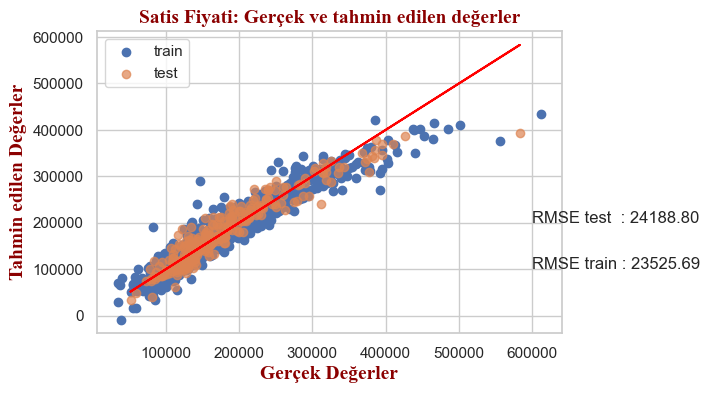

,description,rsquared_train,rsquared_test,MAE,MSE,RMSE,MAPE
model,,,,,,,
1,butun anlamli degiskenlerle,0.895,0.900,"16,936.907","585,098,046.004","24,188.800",10.059


In [36]:
# istenmeyenleri ayir
for var in vars_to_remove:
    if var in expl_vars:
        expl_vars.remove(var)       

# hedef degiskeni
Y = house_prices['SalePrice']
# aciklayici degiskenler
X = house_prices[expl_vars]

# egitim verisini ayirma
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape[0]))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape[0]))

# model nesnesi olusturuldu
lrm = linear_model.LinearRegression()
# modelimizin denklemi (egrisi) olusturuluyor
lrm.fit(X_train, Y_train)

# egitim tahmini
Y_train_pred = lrm.predict(X_train)
# test tahmini
Y_test_pred = lrm.predict(X_test)

# grafigi cizdirelim
make_plot(Y_test, Y_test_pred, Y_train, Y_train_pred)

# model sonuclarini kaydedelim
save_results(lrm, 1, X_train, X_test, Y_train, Y_test, Y_test_pred,
             'butun anlamli degiskenlerle')

# model sonuclari
results_df

---
## ***Regularizasyon***
### ***2. Model (Butun anlamli degiskenlerle - Ridge)***

In [111]:
# en iyi alpha degerini bulmak icin dongu
rmse_best = 50000
alpha_best = 1
for alpha in range(1,1000,1):        
    # ridge regresyonu
    ridgeregr = Ridge(alpha=alpha) 
    ridgeregr.fit(X_train, Y_train)
    # test thamini
    Y_test_pred = ridgeregr.predict(X_test)
    rmse_new = rmse(Y_test, Y_test_pred)
    
    if rmse_new < rmse_best:
        rmse_best = rmse_new
        alpha_best = alpha
        
print('En iyi alpha degeri: {}'.format(alpha_best))

En iyi alpha degeri: 13


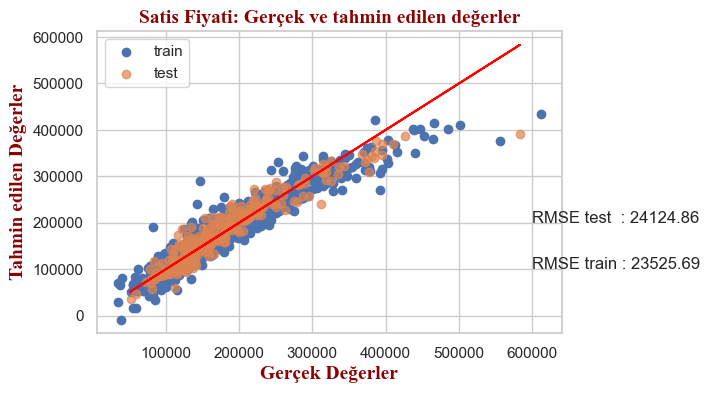

,description,rsquared_train,rsquared_test,MAE,MSE,RMSE,MAPE
model,,,,,,,
1,butun anlamli degiskenlerle,0.895,0.900,"16,936.907","585,098,046.004","24,188.800",10.059
2,butun anlamli degiskenlerle - ridge,0.895,0.900,"16,886.681","582,008,817.180","24,124.859",9.977


In [37]:
# ridge regresyonu
ridgeregr = Ridge(alpha=13) 
ridgeregr.fit(X_train, Y_train)

# test thamini
Y_test_pred = ridgeregr.predict(X_test)

# grafigi cizdirelim
make_plot(Y_test, Y_test_pred, Y_train, Y_train_pred)

# model sonuclarini kaydedelim
save_results(ridgeregr, 2, X_train, X_test, Y_train, Y_test, Y_test_pred,
             'butun anlamli degiskenlerle - ridge')

# model sonuclari
results_df


### ***3. Model (Butun anlamli degiskenlerle - Lasso)***

In [109]:
# en iyi alpha degerini bulmak icin dongu
rmse_best = 50000
alpha_best = 1
for alpha in range(1,1000,1):        
    # ridge regresyonu
    lassoregr = Lasso(alpha=alpha) 
    lassoregr.fit(X_train, Y_train)
    # test thamini
    Y_test_pred = lassoregr.predict(X_test)
    rmse_new = rmse(Y_test, Y_test_pred)
    
    if rmse_new < rmse_best:
        rmse_best = rmse_new
        alpha_best = alpha
        
print('En iyi alpha degeri: {}'.format(alpha_best))

En iyi alpha degeri: 84


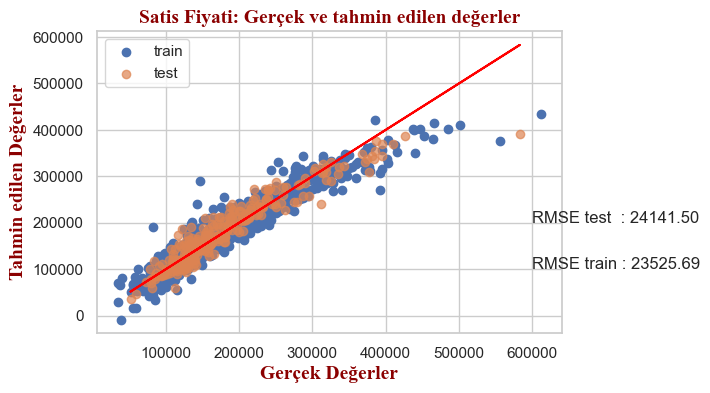

,description,rsquared_train,rsquared_test,MAE,MSE,RMSE,MAPE
model,,,,,,,
1,butun anlamli degiskenlerle,0.895,0.900,"16,936.907","585,098,046.004","24,188.800",10.059
2,butun anlamli degiskenlerle - ridge,0.895,0.900,"16,886.681","582,008,817.180","24,124.859",9.977
3,butun anlamli degiskenlerle - lasso,0.895,0.900,"16,857.458","582,812,164.268","24,141.503",9.938


In [38]:
# lasso regresyonu
lassoregr = Lasso(alpha=84) 
lassoregr.fit(X_train, Y_train)

# test thamini
Y_test_pred = lassoregr.predict(X_test)

# grafigi cizdirelim
make_plot(Y_test, Y_test_pred, Y_train, Y_train_pred)

# model sonuclarini kaydedelim
save_results(lassoregr, 3, X_train, X_test, Y_train, Y_test, Y_test_pred,
             'butun anlamli degiskenlerle - lasso')

# model sonuclari
results_df


### ***4. Model (Butun anlamli degiskenlerle - ElasticNet)***

In [113]:
# en iyi alpha degerini bulmak icin dongu
rmse_best = 50000
alpha_best = 1
l1_ratio_best = 0.1
for l1_ratio in np.arange(0.1,1.5,0.1):
    for alpha in range(1,100,1):        
        # ridge regresyonu
        elasticregr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio) 
        elasticregr.fit(X_train, Y_train)
        # test thamini
        Y_test_pred = elasticregr.predict(X_test)
        rmse_new = rmse(Y_test, Y_test_pred)

        if rmse_new < rmse_best:
            rmse_best = rmse_new
            alpha_best = alpha
            l1_ratio_best = l1_ratio
        
print('En iyi alpha degeri : {}\nEn iyi l1_ratio degeri: {}'.format(alpha_best, l1_ratio_best))

En iyi alpha degeri : 84
En iyi l1_ratio degeri: 1.0


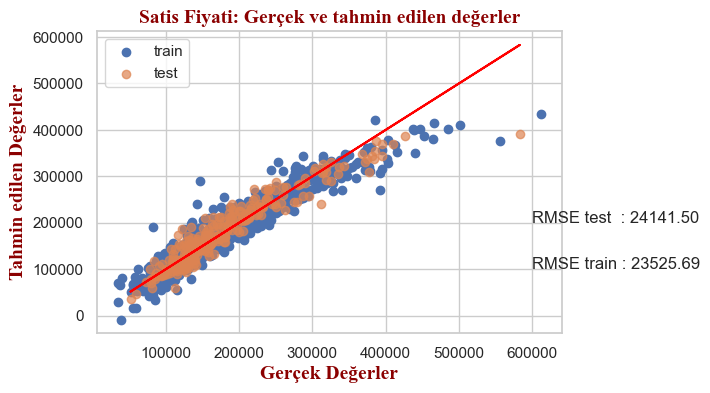

,description,rsquared_train,rsquared_test,MAE,MSE,RMSE,MAPE
model,,,,,,,
1,butun anlamli degiskenlerle,0.895,0.900,"16,936.907","585,098,046.004","24,188.800",10.059
2,butun anlamli degiskenlerle - ridge,0.895,0.900,"16,886.681","582,008,817.180","24,124.859",9.977
3,butun anlamli degiskenlerle - lasso,0.895,0.900,"16,857.458","582,812,164.268","24,141.503",9.938
4,butun anlamli degiskenlerle - elasticnet,0.895,0.900,"16,857.458","582,812,164.268","24,141.503",9.938


In [39]:
# ridge regresyonu
elasticregr = ElasticNet(alpha=84, l1_ratio=1.0) 
elasticregr.fit(X_train, Y_train)

# test thamini
Y_test_pred = elasticregr.predict(X_test)

# grafigi cizdirelim
make_plot(Y_test, Y_test_pred, Y_train, Y_train_pred)

# model sonuclarini kaydedelim
save_results(elasticregr, 4, X_train, X_test, Y_train, Y_test, Y_test_pred,
             'butun anlamli degiskenlerle - elasticnet')

# model sonuclari
results_df
